DeepPredSpeech: Computational models of predictive speech coding based on deep learning 
Jupyter notebook for simulating predictive coding of speech from any speech audio signals using a predictive model trained on LibriSpeech dataset
T. Hueber - CNRS/GIPSA-lab - 2019
thomas.hueber@gipsa-lab.fr

In [1]:
# import the required packages
from __future__ import print_function
import numpy as np
import scipy
import scipy.io as sio
from scipy import fftpack
import matplotlib.pyplot as plt
import os
import librosa
from librosa import display
from os import listdir, mkdir, system
from os.path import join, isdir, basename, splitext
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.externals import joblib
import glob
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Merge, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils, plot_model
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
import soundfile as sf
import tensorflow as tf
from keras import backend as k

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [53]:
# Load audio file (WAVE, 16kHz, 16 bits)
target_audio_filename = "./data/audio/2691-156755-0004.flac"

# Set some simulation parameters
tau_p = 3 #should be either 0, 1, 2, 3 or 4
tau_f = 6 # should be either 0,1,2,3,4,6,8,10,14 or 18 (assuming 25ms frame shift and frame size - i.e. no overlap between 2 consecutive frames)

batch_size = 256 # used only at training time but required by keras at test time


In [34]:
# Load pre-trained data normalizer and model

model_audio = load_model('./data/pretrained_model/model_audio_' + str(tau_p) + '_' + str(tau_f) + '.h5')
model_audio.summary()
audio_min_max_scaler_in = joblib.load('./data/pretrained_model/audio_min_max_scaler_in_' + str(tau_p) + '_' + str(tau_f) + '.dat')
audio_min_max_scaler_out = joblib.load('./data/pretrained_model/audio_min_max_scaler_out_' + str(tau_p) + '_' + str(tau_f) + '.dat')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 52)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_106 (Bat (None, 256)               1024      
_________________________________________________________________
activation_106 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 256)               65792     
_________________________________________________________________
batch_normalization_107 (Bat (None, 256)               1024      
__________

In [4]:
# Define some functions to pre-process the data
def build_inout(indata,tp,tf):
    indata_context = []
    for r in range(tp,(np.shape(indata)[0]-tf)):
        tmp = indata[r,:]
        for p in range(tp):
            tmp = np.append(tmp,indata[r-(p+1),:],axis=0)
            #print(tmp)
        if r==tp:
            indata_context = tmp;
        else:
            indata_context = np.vstack([indata_context,tmp])
            
    outdata = indata[range(tf+tp,np.shape(indata)[0]),:]
          
    return indata_context, outdata

In [54]:
# Define some parameters and a function for MFCC feature extraction 
n_mels = 40
n_fft = 512
window = 'hamming'
fmin = 20
fmax = 8000
n_mfcc = 13
win_length = 400 #i.e. 0.025 ms at 16kHz
hop_length = 400 #i.e. 0.025 ms at 16kHz

def extract_mfcc(audio_filename):

    # Load audio file
    y, sr = librosa.load(audio_filename,sr=None)

    # Comput MFCC
    D = np.abs(librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length))**2
    S = librosa.feature.melspectrogram(S=D, y=y, n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)
    mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    
    return mfcc_features.transpose()

In [55]:
# Extract MFCC 
target_audio_mfcc = extract_mfcc(target_audio_filename)

# Build in/out data (i.e. add past context and define target frame to predict) 
audio_features_with_past_context, audio_features_target = build_inout(target_audio_mfcc,tau_p,tau_f)

# Normalize input data 
audio_features_in_norm = audio_min_max_scaler_in.transform(audio_features_with_past_context) 

# Do some sanity check
np.shape(audio_features_in_norm)

(491, 52)

In [35]:
# Predict audio frames at t+tau_p
audio_features_out_predict_from_audio = model_audio.predict(audio_features_in_norm, batch_size=batch_size)
            
# Denormalize predicted values
audio_features_out_predict_from_audio_denorm = audio_min_max_scaler_out.inverse_transform(audio_features_out_predict_from_audio)

# Calculate RMSE for each frame
current_sentence_mse_audio = np.zeros((np.shape(audio_features_out_predict_from_audio_denorm)[0]))
for fr in range(np.shape(audio_features_out_predict_from_audio_denorm)[0]):
    current_sentence_mse_audio[fr]=mean_squared_error(audio_features_target[fr,:], audio_features_out_predict_from_audio_denorm[fr,:])
    
# Calculate the Explained variance regression score (MSE/VAR)
evr_audio = explained_variance_score(audio_features_target, audio_features_out_predict_from_audio_denorm,multioutput='variance_weighted')

print("Explained variance: %.2f" % (evr_audio))
print("Prediction gain : %.2f" % (1/(1-evr_audio)))

Explained variance: 0.31
Prediction gain : 1.46


(0, 495)

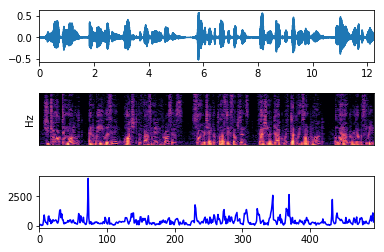

In [52]:
# Display results

# Load audio waveform
y, sr = librosa.load(target_audio_filename,sr=None)

# remove tau_p frames at the begining and tau_f frames at the end of the audio file
first_valid_sample = tau_p*hop_length
last_valid_sample = np.shape(y)[0]-(tau_f*hop_length)
y_crop = y[range(first_valid_sample,last_valid_sample)]
t_data = np.arange(0,np.shape(y_crop)[0]/float(sr),1/float(sr))

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.4)

fig.add_subplot(3, 1, 1)
plt.plot(t_data, y_crop) 
plt.xlim((0,t_data[-1]))
#plt.yticks(())
                
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_crop)), ref=np.max)
fig.add_subplot(3, 1, 2)
librosa.display.specshow(D, y_axis='linear',sr=16000)
#plt.colorbar(format='%+2.0f dB')
#plt.title('Linear-frequency power spectrogram')
plt.yticks(())

fig.add_subplot(3, 1, 3)
plt.plot(current_sentence_mse_audio,'b')
plt.xlim((0,np.shape(current_sentence_mse_audio)[0]))
         